In [1]:
# Import
import pandas as pd
from pyproj import Transformer
from pointpats import PointPattern
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import osmnx as ox
import myutils
%matplotlib inline

In [2]:
import os
os.getcwd()

'e:\\Urban Informatics\\01-Spatial\\Coursework\\Code'

## Introduction
Road safety has long been a big concern for public citizens for it is related to every aspect of daily life: work and school commuting, weekly shopping and hangout, and even tourism. Accoring to road casualities annual report conducted by British National road safety statistics department, although road casualties number in Great Britain in 2020 is decresing in terms of all kinds of severities and most of vihicle types compared with 2019(cite 1), road safety is still a severe problem that need to concern because the dropping number might be caused by COVID-19 pandemic.

In this report, there are two main research questions: 1) where are the car accident hotpots around the Great London. 2) when car accidents are more likely to happen. For the first question, it can be divided into several parts: By using kernal density estimation, we can figure out that is there any salient hotpots across the Great London? By using quadrat analysis, we can explore are there specific areas or local authorities have high pissibility of road accident casualty need to pay extra attention? By using network analysis, we can investigate whether car accidents are more likely happen near junctions or along the pathway? For the second reasearch question, this report will evalutate car accidents distribution on a temporal aspect and select a fixed period to do a geographical regression to find out poossible reasons lead to the high number of car accidents.

For point data ananlysis, there are some popular methods such as nearest neighbour, quadrat analysis, and clustering analysis(cite2), Kernel density estimation and K-means clustering(cite3) My initial idea here is 




cite 1:
https://www.gov.uk/government/statistics/reported-road-casualties-great-britain-annual-report-2020/reported-road-casualties-great-britain-annual-report-2020#casualties-by-vehicles-involved-in-accidents

cite2: 
Gatrell, A. C., Bailey, T. C., Diggle, P. J., & Rowlingson, B. S. (1996). Spatial point pattern analysis and its application in geographical epidemiology. Transactions of the Institute of British geographers, 256-274.

cite3:
Anderson, T. K. (2009). Kernel density estimation and K-means clustering to profile road accident hotspots. Accident Analysis & Prevention, 41(3), 359-364.



In [3]:
# Data source:
# https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safet   y-data
vehicle = pd.read_csv("../Data/dft-road-casualty-statistics-vehicle-provisional-mid-year-unvalidated-2021.csv")
# vehicle.columns
# vehicle.info()
# vehicle.groupby(["pedal_cycling"]).size().sort_values()

Let's have a brief look at accidents by vehicle types. Vehicle types we are interested in are "8": taxi and private hired car and "9":Car. Here we don't consider pedal cycle, motorcycle, bus or coach,, ridden horse, tram, van scrooter, and other vihicles.

In [4]:
vehicle.groupby(["vehicle_type"]).size().sort_values(ascending=False)

vehicle_type
 9     52684
 1      7547
 19     4663
 3      3456
 5      1488
 98     1419
 90     1220
 8      1132
 11     1094
 21      860
 97      739
 4       659
 2       495
 20      298
 17      145
-1       139
 10      116
 22      105
 23       87
 16       47
 99       12
 18        6
dtype: int64

In [5]:

vehicle = vehicle.loc[(vehicle["vehicle_type"] == 9) | (vehicle["vehicle_type"] == 8)].reset_index(drop = True)[["accident_index", "accident_year", "accident_reference"]]

In [6]:
# Data source:
# https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data
accident = pd.read_csv("../Data/dft-road-casualty-statistics-accident-provisional-mid-year-unvalidated-2021.csv")
# accident.groupby(["longitude"]).size().sort_values()

In [7]:
accident.columns

Index(['status', 'accident_index', 'accident_year', 'accident_reference',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location'],
      dtype='object')

In [8]:
# Converting grid reference to long and lat
transformer = Transformer.from_crs("EPSG:27700", "EPSG:4326")
accident["latitude"], accident["longitude"] = transformer.transform(accident["location_easting_osgr"], accident["location_northing_osgr"])

In [9]:
# filter pedal bike accidents
reference_num = vehicle["accident_reference"].tolist()
car_accidents = accident.loc[accident["accident_reference"].isin(reference_num)]
# data limitation: some accidents may be ignored due to no reference number to connect
missing_per =  round((1- len(accident.loc[accident["accident_reference"].isin(reference_num)])/len(reference_num))*100, 2)
print("{} percentage of accident data are ignored".format(missing_per))
# filter points only in Great London
car_accidents = car_accidents.loc[
                    (car_accidents["police_force"] == 1)
                    | (car_accidents["police_force"] == 48)]

# only select usful columns
car_accidents = car_accidents[["accident_reference", "accident_year", "longitude", "latitude", "location_easting_osgr", "location_northing_osgr",
    "accident_severity", "road_type", "speed_limit", "junction_control", "junction_detail", "road_surface_conditions", "day_of_week", "time"]]
# car_accidents.info()

32.51 percentage of accident data are ignored


In [10]:
car_accidents.head()

,accident_reference,accident_year,longitude,latitude,location_easting_osgr,location_northing_osgr,accident_severity,road_type,speed_limit,junction_control,junction_detail,road_surface_conditions,day_of_week,time
0,010287148,2021,-0.246102,51.623425,521508.0,193079.0,3,6,30,4,9,4,6,02:05
1,010287149,2021,-0.050574,51.509767,535379.0,180783.0,2,3,30,2,7,1,6,03:30
2,010287151,2021,-0.136152,51.417769,529701.0,170398.0,2,6,30,2,9,1,6,04:07
3,010287155,2021,-0.196411,51.490536,525312.0,178385.0,1,2,30,4,9,1,6,04:26
4,010287157,2021,-0.388169,51.431649,512144.0,171526.0,3,6,20,4,3,1,6,03:10


In [11]:
car_accidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8354 entries, 0 to 39402
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   accident_reference       8354 non-null   object 
 1   accident_year            8354 non-null   int64  
 2   longitude                8354 non-null   float64
 3   latitude                 8354 non-null   float64
 4   location_easting_osgr    8183 non-null   float64
 5   location_northing_osgr   8183 non-null   float64
 6   accident_severity        8354 non-null   int64  
 7   road_type                8354 non-null   int64  
 8   speed_limit              8354 non-null   int64  
 9   junction_control         8354 non-null   int64  
 10  junction_detail          8354 non-null   int64  
 11  road_surface_conditions  8354 non-null   int64  
 12  day_of_week              8354 non-null   int64  
 13  time                     8354 non-null   object 
dtypes: float64(4), int64(8)

In [12]:

# drop inf values
before_drop_num = len(car_accidents)
car_accidents.drop(car_accidents.index[(car_accidents == np.inf).any(axis=1)], inplace=True)
after_drop_num = len(car_accidents)
sub = before_drop_num -after_drop_num
print("{} rows have been dropped, there are now {} accidents for analysis.".format(sub, after_drop_num))


171 rows have been dropped, there are now 8183 accidents for analysis.


# Quadrat Based Statistics

In [2]:
import pointpats.quadrat_statistics as qs
from libpysal.cg import shapely_ext
import libpysal as lps
lsoas_gdf = lps.io.open ('../Data/LSOA_IMD2019.shp').read() 

# define the polygon shapes from London lsoa data
polys = [shp for shp in lsoas_gdf] 
# Create the exterior polygons for Greater London from the union of the polygon shapes
boundary = shapely_ext.cascaded_union(polys)

accidents_point = car_accidents[["location_easting_osgr", "location_northing_osgr"]].to_numpy().tolist()
pp_accidents = PointPattern(accidents_point, window=boundary)
pp_accidents.plot(window=True, title= "London 2021 car accident pattern")

NameError: name 'car_accidents' is not defined

<Figure size 1440x864 with 0 Axes>

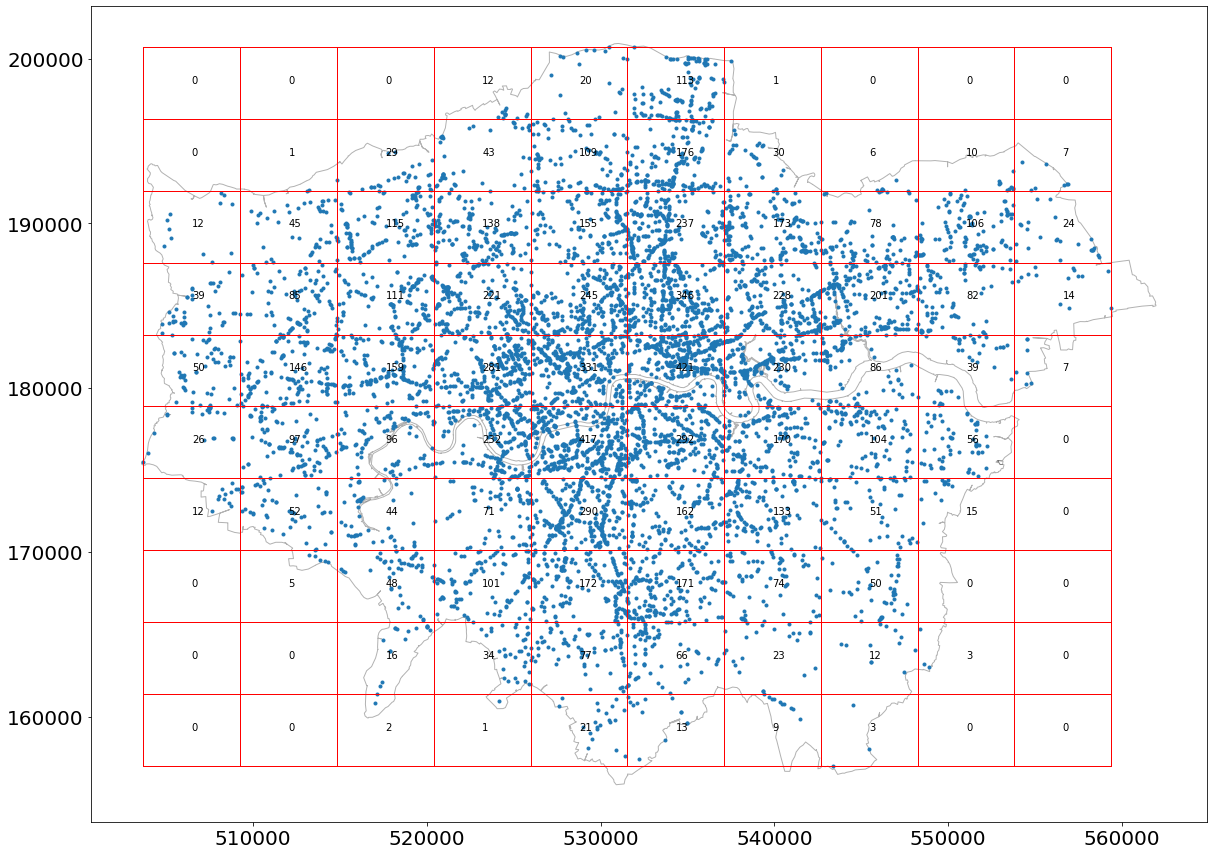

In [14]:
# f, ax = plt.subplots(1, figsize=(20,20))
plt.figure(figsize=(20, 12))
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams["figure.figsize"] = (20,15)
q_r_pubs = qs.QStatistic(pp_accidents,shape= "rectangle",nx = 10, ny = 10)
q_r_pubs.plot(title= "") # plot out the quadrat count figure with 4*4 windows

In [15]:
print('Chi-squared test statistic for the observed point pattern is: '+ str(q_r_pubs.chi2)) 
print('Degree of freedom is: '+str(q_r_pubs.df)) 
print('P-valus for Chi-squared test statistic is: '+str.format('{0:.6f}', q_r_pubs.chi2_pvalue)) # 6 decimals

Chi-squared test statistic for the observed point pattern is: 12057.90186972993
Degree of freedom is: 99
P-valus for Chi-squared test statistic is: 0.000000


In [4]:
lsoas_gdf = gpd.read_file('../Data/LSOA_IMD2019.shp')
lsoas_gdf = lsoas_gdf[['LSOA11CD', 'LSOA11NM', 'geometry']]
colnames = ['code','lsoa','geometry']
lsoas_gdf.columns = colnames

In [17]:
lsoas_gdf.head()

,code,lsoa,geometry
0,E01000001,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18..."


In [18]:
car_accidents = gpd.GeoDataFrame(car_accidents, crs = "EPSG:27700", 
    geometry = [Point(xy) for xy in zip(car_accidents["location_easting_osgr"], car_accidents["location_northing_osgr"])]
)

In [19]:
joined_accident = gpd.sjoin(car_accidents, lsoas_gdf, how = "right")
# some lsoa may don't have accidents, so fill them with 0
joined_accident = joined_accident.dropna().drop(columns = ["index_left", "accident_year"]).reset_index(drop = True)

In [20]:
joined_accident.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8164 entries, 0 to 8163
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   accident_reference       8164 non-null   object  
 1   longitude                8164 non-null   float64 
 2   latitude                 8164 non-null   float64 
 3   location_easting_osgr    8164 non-null   float64 
 4   location_northing_osgr   8164 non-null   float64 
 5   accident_severity        8164 non-null   float64 
 6   road_type                8164 non-null   float64 
 7   speed_limit              8164 non-null   float64 
 8   junction_control         8164 non-null   float64 
 9   junction_detail          8164 non-null   float64 
 10  road_surface_conditions  8164 non-null   float64 
 11  day_of_week              8164 non-null   float64 
 12  time                     8164 non-null   object  
 13  code                     8164 non-null   object  
 14  

In [21]:
# Find car accidents density by lsoa and plot it
# calculate the total number of car accidents per lsoa in 2021
lsoas_accident_count = pd.DataFrame(joined_accident['lsoa'].value_counts().astype(int)).reset_index()
# only leave the 2 columns for plot generating
lsoas_accident_count.columns = ['lsoa','accident_num']
lsoas_accident_count.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lsoa          3147 non-null   object
 1   accident_num  3147 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 37.0+ KB


<ipython-input-22-63784ff095b2>:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  accidents_per_lsoa.to_file(driver='ESRI Shapefile', filename='lsoa_accident.shp')


<AxesSubplot:>

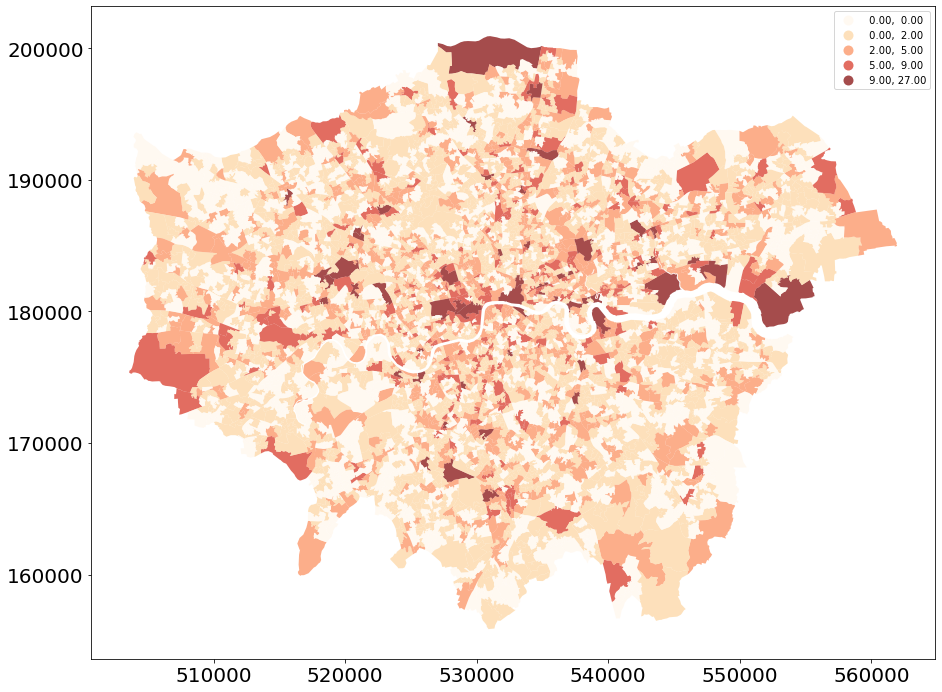

In [22]:
# add a new column of pubs number in each lsoa 
# by join lsoa and pubs through attribute join
accidents_per_lsoa = joined_accident.merge(lsoas_accident_count, on='lsoa', how = "right")[["lsoa", "geometry", "accident_num"]].drop_duplicates()
accidents_per_lsoa = accidents_per_lsoa.merge(lsoas_gdf, on = "lsoa", how = "right").drop(columns = ["geometry_x"]).fillna(0)
accidents_per_lsoa = accidents_per_lsoa.rename(columns = {"geometry_y": "geometry"})

accidents_per_lsoa = gpd.GeoDataFrame(accidents_per_lsoa, crs = "EPSG:27700")
# save this newly joined .csv file into .shp file
accidents_per_lsoa.to_file(driver='ESRI Shapefile', filename='lsoa_accident.shp')
# Make a Choropleth map on pubs per lsoa.
f, ax = plt.subplots(1, figsize=(20,12))
accidents_per_lsoa.plot(column='accident_num', cmap='OrRd', scheme='natural_breaks', k=5, alpha=0.7, legend=True, ax = ax)

As we can see from this plot, which is classified into five quantiles, some areas have the apprently high number than others. For example areas in the central london, along the Times River, and the North, West, and East boader. However, this putput only shows the raw count data in each lsoa, without taking into account of the road density of each lsoa. To be more precisely, if we want the density map, we shold 

In [23]:
# data source: https://github.com/npalomin/streetspace_dataset_ldn
road_df = gpd.read_file("../Data/streetspace_dataset_ldn.gpkg/streetspace_dataset_ldn.gpkg")

D:\software\Anaconda\envs\msda2021\lib\site-packages\geopandas\geodataframe.py:600: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [24]:
road_df

,id,DISTNAME,ROADNUMBER,CLASSIFICA,foW,caW,toW,geometry
0,199200.0,Steynton Avenue,None,Local Road,5.090000,6.190000,11.280000,"MULTILINESTRING ((548034.001 172953.000, 54789..."
1,199200.0,Steynton Avenue,None,Local Road,5.090000,6.190000,11.280000,GEOMETRYCOLLECTION EMPTY
2,191722.0,Station Road,None,Local Road,2.200000,8.680000,10.880000,"MULTILINESTRING ((548234.001 175983.000, 54832..."
3,191722.0,Station Road,None,Local Road,2.200000,8.680000,10.880000,"MULTILINESTRING ((548323.679 175981.522, 54841..."
4,35284.0,Chequers Lane,None,Local Road,6.830000,9.140000,15.970000,"MULTILINESTRING ((549051.130 183119.970, 54903..."
...,...,...,...,...,...,...,...,...
273877,86730.0,St Katharine's Way,None,Local Road,6.387537,8.022978,14.410515,"MULTILINESTRING ((533924.000 180377.000, 53393..."
273878,86731.0,St Katharine's Way,None,Local Road,6.387537,8.022978,14.410515,"MULTILINESTRING ((533938.000 180358.000, 53398..."
273879,53609.0,Holywell Lane,None,Minor Road,7.802825,9.214601,17.017426,"MULTILINESTRING ((533374.040 182284.800, 53348..."
273880,91111.0,King William Street,A3,"A Road, Collapsed Dual Carriageway",12.876468,18.656715,31.533184,"MULTILINESTRING ((532844.430 180705.690, 53277..."


In [25]:
lsoas_gdf

,code,lsoa,geometry
0,E01000001,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18..."
...,...,...,...
4830,E01033742,Greenwich 007F,"POLYGON ((544642.680 179824.674, 544766.313 17..."
4831,E01033743,Greenwich 002H,"POLYGON ((546579.195 181097.813, 546687.036 18..."
4832,E01033744,Greenwich 007G,"POLYGON ((544536.486 179447.115, 544602.630 17..."
4833,E01033745,Greenwich 002I,"POLYGON ((546415.745 180152.270, 546320.715 18..."


In [26]:
road_join = gpd.sjoin(lsoas_gdf, road_df, how="left")
road_join = road_join.drop(columns = ["index_right"])

<ipython-input-26-e0773a858f72>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: PROJCS["unnamed",GEOGCS["Airy 1830",DATUM["unknown ...

  road_join = gpd.sjoin(lsoas_gdf, road_df, how="left")


In [27]:
# road classification
# https://www.ordnancesurvey.co.uk/xml/codelists/map/RoadClassificationTypeOML.xml
myutils.group_by_count(road_df, "CLASSIFICA")

CLASSIFICA
Local Road                                  188507
Minor Road                                   35400
A Road                                       22614
B Road                                       10489
Primary Road                                  6176
Primary Road, Collapsed Dual Carriageway      3630
A Road, Collapsed Dual Carriageway            3000
Motorway                                      1404
Motorway, Collapsed Dual Carriageway          1313
Minor Road, Collapsed Dual Carriageway         673
B Road, Collapsed Dual Carriageway             380
Shared Use Carriageway                         296
dtype: int64

In [28]:
lsoa_road_counts = pd.DataFrame(myutils.group_by_count(road_join, "code")).reset_index()
# only leave the 2 columns for plot generating
lsoa_road_counts.columns = ['code','road_num']

In [29]:
accidents_per_lsoa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   lsoa          4835 non-null   object  
 1   accident_num  4835 non-null   float64 
 2   code          4835 non-null   object  
 3   geometry      4835 non-null   geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 188.9+ KB


In [30]:
accidents_per_lsoa.merge(lsoa_road_counts, on='code', how = "left").head(3)

,lsoa,accident_num,code,geometry,road_num
0,City of London 001A,0.0,E01000001,"POLYGON ((532105.092 182011.230, 532162.491 18...",52
1,City of London 001B,0.0,E01000002,"POLYGON ((532746.813 181786.891, 532671.688 18...",60
2,City of London 001C,0.0,E01000003,"POLYGON ((532135.145 182198.119, 532158.250 18...",15


<AxesSubplot:>

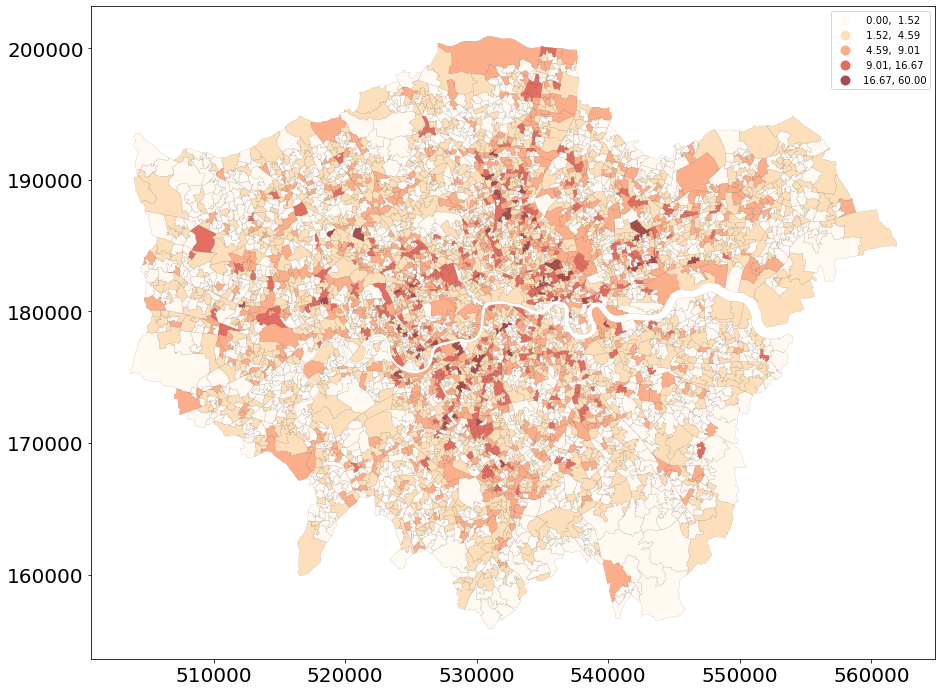

In [31]:
# add a new column of pubs number in each lsoa 
# by join lsoa and pubs through attribute join
merged_1 = accidents_per_lsoa.merge(lsoa_road_counts, on='code', how = "left")
merged_1["road_density"] = merged_1.apply(lambda row: 100 * row.accident_num / row.road_num, axis=1)
# Make a Choropleth map on pubs per lsoa.
f, ax = plt.subplots(1, figsize=(20,12))
merged_1.plot(column='road_density', cmap='OrRd', alpha=0.7, scheme='natural_breaks', k=5, legend=True, ax = ax, edgecolor='k', linewidth=0.1)

After considering the road number of each lsoa, we obtained a significant different plot as the former one. If we define Great London as three circle, inner, secondary inner, and the outter, we can see that the accidents distribution of the former plot is condense distributed on the inner circle, and the outter circle. However, when we take road density into consideration, the secondary inner circle will be the more dense area. In this report, we will only focus on the high density lsoas.

Now the following steps are:

1. Filter the high density lsoa, plot the distribution of accident time.
2. Are there any difference between weekends and week days?

In [32]:
joined_accident.merge(lsoas_accident_count, on='lsoa', how = "right").info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 8164 entries, 0 to 8163
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   accident_reference       8164 non-null   object  
 1   longitude                8164 non-null   float64 
 2   latitude                 8164 non-null   float64 
 3   location_easting_osgr    8164 non-null   float64 
 4   location_northing_osgr   8164 non-null   float64 
 5   accident_severity        8164 non-null   float64 
 6   road_type                8164 non-null   float64 
 7   speed_limit              8164 non-null   float64 
 8   junction_control         8164 non-null   float64 
 9   junction_detail          8164 non-null   float64 
 10  road_surface_conditions  8164 non-null   float64 
 11  day_of_week              8164 non-null   float64 
 12  time                     8164 non-null   object  
 13  code                     8164 non-null   object  
 14  

In [33]:
# Filter high lsoa
merge_2 = joined_accident.merge(lsoas_accident_count, on='lsoa', how = "right")
merge_2 = merge_2.merge(merged_1, on='lsoa', how = "left")[["accident_reference", "day_of_week", "time", "code_x", "lsoa", "geometry_x", "road_density", "location_easting_osgr", "location_northing_osgr"]]
merge_2 = merge_2.rename(columns = {"code_x": "code", "geometry_x": "geometry", "location_easting_osgr": "east", "location_northing_osgr": "north"})
merge_2 = gpd.GeoDataFrame(merge_2, crs ="EPSG:27700")
high_density = merge_2.loc[merge_2["road_density"] > 10.87].reset_index(drop = True)
weekdays_accident = high_density.loc[high_density["day_of_week"].astype(int) < 6].reset_index(drop = True)
weekend_accident = high_density.loc[high_density["day_of_week"].astype(int) > 5].reset_index(drop = True)

In [34]:
merge_2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 8164 entries, 0 to 8163
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accident_reference  8164 non-null   object  
 1   day_of_week         8164 non-null   float64 
 2   time                8164 non-null   object  
 3   code                8164 non-null   object  
 4   lsoa                8164 non-null   object  
 5   geometry            8164 non-null   geometry
 6   road_density        8164 non-null   float64 
 7   east                8164 non-null   float64 
 8   north               8164 non-null   float64 
dtypes: float64(4), geometry(1), object(4)
memory usage: 637.8+ KB


<AxesSubplot:xlabel='Time of a day', ylabel='Count'>

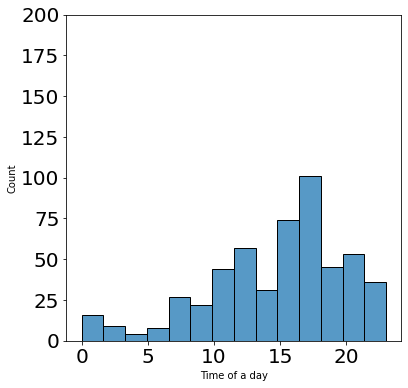

In [35]:
f, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_ylim(0,200)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.xlabel("Time of a day")
sns.histplot(weekend_accident["time"].str.split(":", expand=True)[0].astype(int), ax=ax)

D:\software\Anaconda\envs\msda2021\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='east', ylabel='north'>

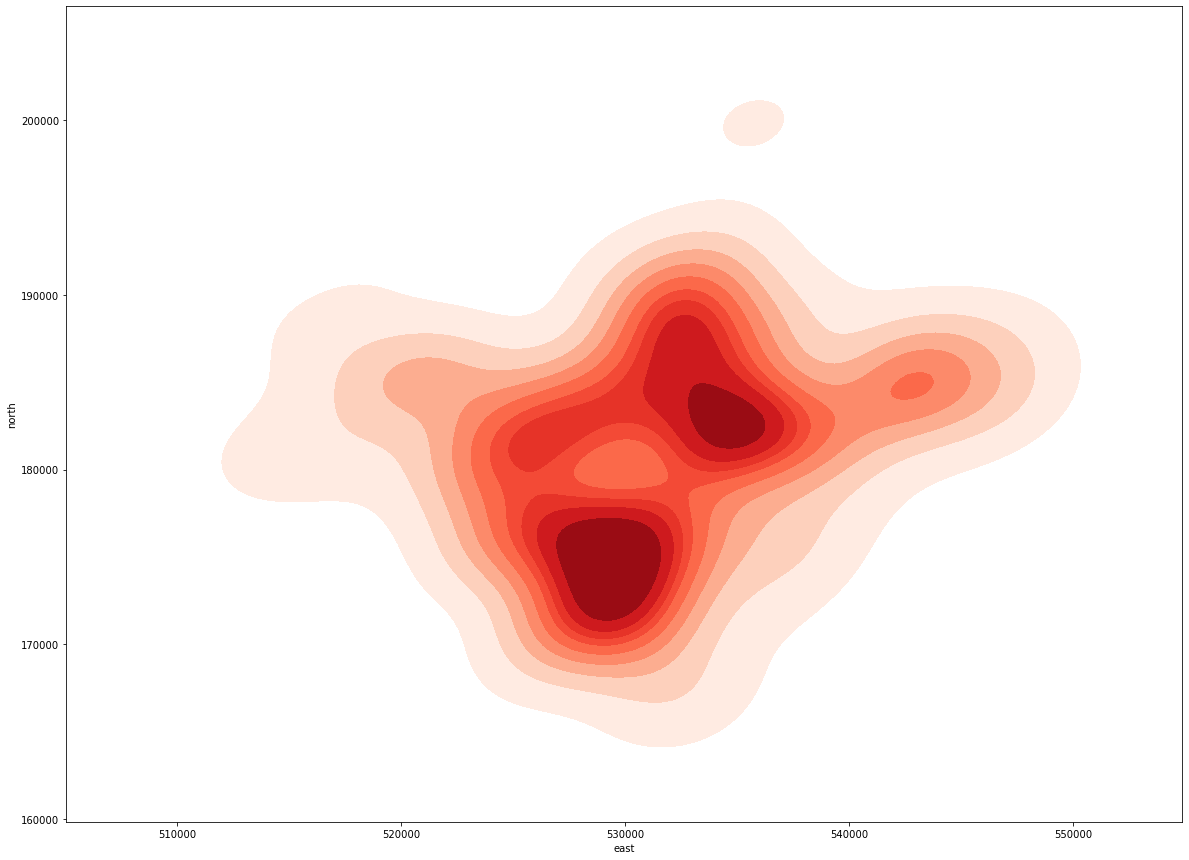

In [36]:
sns.kdeplot(weekend_accident.east, weekend_accident.north, shade = True, cmap = 'Reds')

<AxesSubplot:xlabel='Time of a day', ylabel='Count'>

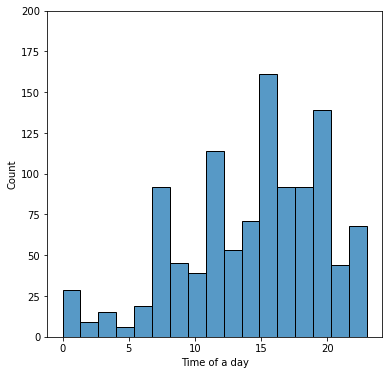

In [37]:
f, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_ylim(0, 200)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.xlabel("Time of a day")
sns.histplot(weekdays_accident["time"].str.split(":", expand=True)[0].astype(int), ax=ax)

D:\software\Anaconda\envs\msda2021\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='east', ylabel='north'>

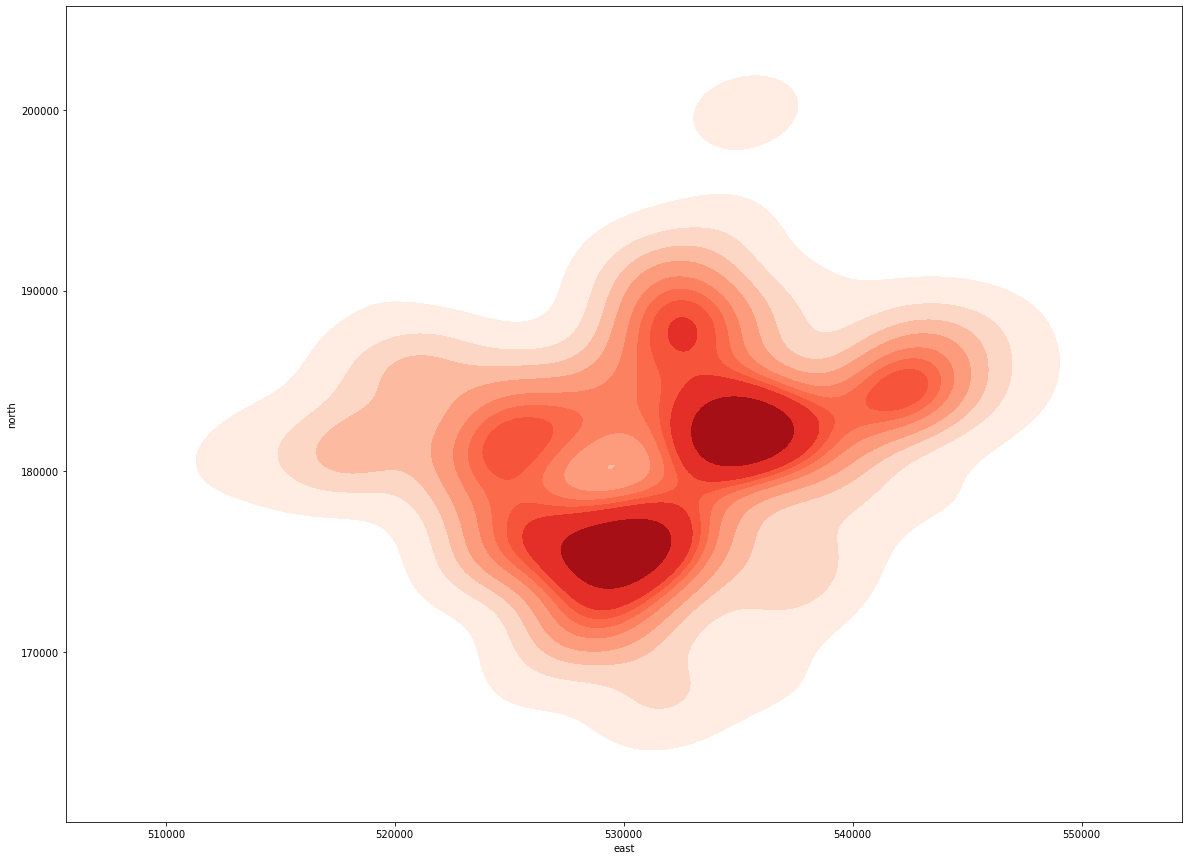

In [38]:
sns.kdeplot(weekdays_accident.east, weekdays_accident.north, shade = True, cmap = 'Reds')

## Junction

In [39]:
junction_detail_group = myutils.group_by_count(car_accidents, "junction_detail")
junction_detail_group_df = junction_detail_group.to_frame().reset_index()
junction_detail_group_df.columns = ["juction_details", "count"]
num_all = junction_detail_group_df["count"].sum()
num_is_junc = num_all - 1677
num_is_junc_per = round(100 * num_is_junc/num_all, 2)
print("{} are in junction, taken up {} percent of all".format(num_is_junc, num_is_junc_per))

6506 are in junction, taken up 79.51 percent of all


In [40]:
junction_detail_group

junction_detail
3     2604
0     1652
6     1032
9      797
99     753
1      511
7      265
5      232
8      201
2      136
dtype: int64

In [41]:
myutils.group_by_count(car_accidents, "junction_control")

junction_control
 4    3996
 2    1717
-1    1652
 9     667
 3     104
 1      47
dtype: int64

In [42]:
junction_control_group = myutils.group_by_count(car_accidents, "junction_control")
junction_control_group_df = junction_control_group.to_frame().reset_index()
junction_control_group_df.columns = ["juction_control", "count"]
num_control_all = junction_control_group_df["count"].sum()
num_is_give = 4077  # no signal
num_is_give_per = round(100 * num_is_give/num_control_all, 2)
print("{} are give way and no signals, taken up {} percent of all".format(num_is_give, num_is_give_per))

4077 are give way and no signals, taken up 49.82 percent of all


As we can can see from junction analysis, almost 80% of the car accidents are close to juntions(either crossroad, T junction, roundabout, and other junctions). Nearly 49% are happened in the junction where there is give way or no other traffic signals. 

In [43]:
cross_df = car_accidents.groupby(["junction_detail", "junction_control"]).size().reset_index()
cross_df.columns = ["junction_detail", "junction_control", "counts"]
cross_df["percentage"] = cross_df['counts'] / cross_df.groupby(["junction_detail"])['counts'].transform('sum')
# This can be made as a table

In [44]:
cross_df

,junction_detail,junction_control,counts,percentage
0,0,-1,1652,1.000000
1,1,1,6,0.011742
2,1,2,153,0.299413
3,1,3,4,0.007828
4,1,4,348,0.681018
5,2,1,3,0.022059
6,2,2,7,0.051471
7,2,3,1,0.007353
8,2,4,125,0.919118
9,3,1,7,0.002688


So far, we have figured out the the general accidents counts distribution and road number based density distribution across all lsoa of Great London, and spotted some hotpots under the two methods respectively. Besides, when diving into high density areas, we found that the pattern of weekdays and weekends are different. 1) For total number of accidents, weekdays have more accidents than weekends. 2) The "peak" period, most accidents happend, of weekdays is more than weekends. For example, around 8 am, 11 am, 15 pm, 20 pm are the peak period in weekdays, while only 17 pm on weekends is the peak period.  3) From kernal density plot, we found that both of weekends and weekdays have two dense spots, but weekends share a more sparse distribution since "less red" areas are more broad than weekdays. The reason to explain these three findings might be: 1) People are busy in different time period of a day in weekdays, therefore more likely to drive in hurry, leading to colision n several time period. 2) Weekdays are the days more aiming leading than weekend, people are heading to some specific places like working places, business centres, railway stations, metro station, and etc. However, the aim of driving will be more leisure, therefore people have various destintions and the possibility of accidents collision will distributed more sparsely.

The following analysis will focus on why some areas have high number/high density of car accidents while others remain in a low level? What might be the possible factors to affect the accident colission? Here we will only focus on the high density lsoas and try to do a geographical regression.

Possible variables: road density(counts/area), junction densitys(counts/area), traffic congestion index, bus station density(counts/area), metro station density(counts/area), 

# Kernal density estimation
In this part, we use Gussain as kernel.

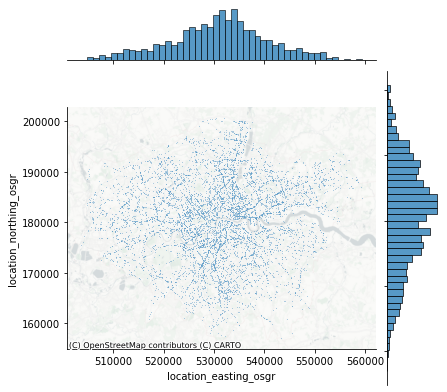

In [46]:
import contextily
# Generate scatter plot
joint_axes = sns.jointplot(
    x='location_easting_osgr', y='location_northing_osgr', data=joined_accident, s=0.5
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:27700",
    source=contextily.providers.CartoDB.PositronNoLabels
)

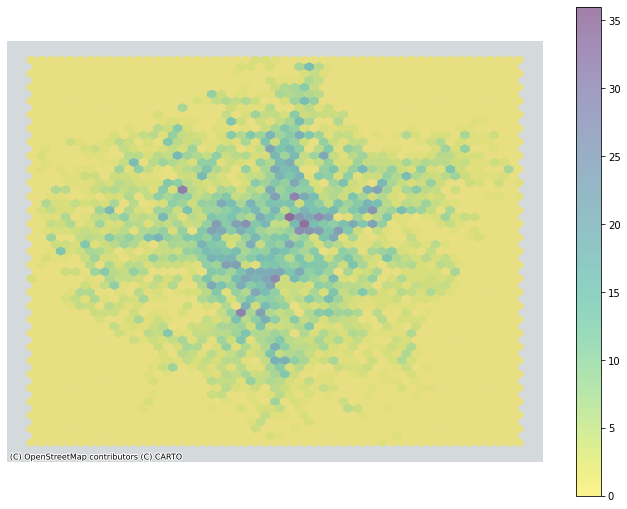

In [47]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each 
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    joined_accident['location_easting_osgr'], 
    joined_accident['location_northing_osgr'],
    gridsize=50, 
    linewidths=0,
    alpha=0.5, 
    cmap='viridis_r'
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)
# Add colorbar
plt.colorbar(hb)
# Remove axes


D:\software\Anaconda\envs\msda2021\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\software\Anaconda\envs\msda2021\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


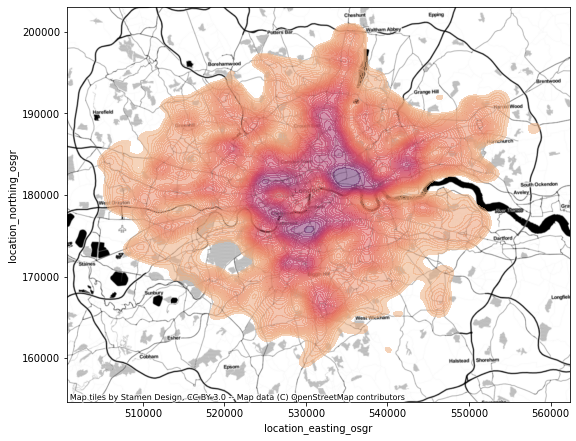

In [48]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients 
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
cmap = sns.color_palette("flare", n_colors=5, as_cmap=True)
sns.kdeplot(
    joined_accident['location_easting_osgr'], 
    joined_accident['location_northing_osgr'],
    n_levels=50, 
    fill=True,
    alpha=0.55, 
    bw=0.1,
    cmap=cmap,
    legend=True
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.Stamen.Toner,
    crs = "EPSG:27700"
)

# set axes
# ax.set_axis_off()

In [50]:
import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster, FastMarkerCluster
# Ensure you're handing it floats
joined_accident['lat'] = joined_accident['latitude'].astype(float)
joined_accident['lon'] = joined_accident['longitude'].astype(float)


# Filter the DF for rows, then columns, then remove NaNs
heat_df = joined_accident[['lat', 'lon']]
heat_df = heat_df.dropna(axis=0, subset=['lat','lon'])

# List comprehension to make out list of lists
heat_data = [[row['lat'],row['lon']] for index, row in heat_df.iterrows()]

heatmap_map = folium.Map([51.50632, -0.1271448], zoom_start=5, tiles="Stamen Toner", control_scale=True) # 

# Plot it on the map
gradient={'1':'#701f57', '0.75':'#ad1759','0.5':'#e13342', '0.25':'#f37651','0': '#f6b48f'}
hm=plugins.HeatMap(heat_data, min_opacity=0.1,radius=20, gradient=gradient)
heatmap_map.add_child(hm)
# get the map shown below 
# if it is blank for browser reason, please save it as html file
heatmap_map

# Local pattern

In [172]:
import osmnx as ox
# are: around 35000000 squres
# point: snear queen mary university
qm_north, qm_south, qm_east, qm_west = ox.utils_geo.bbox_from_point((51.523776930594344, -0.03843224516308102), dist = 3000)
qm_graph = ox.graph_from_bbox(qm_north, qm_south, qm_east, qm_west, network_type='drive', simplify = True)
# project map, from "EPSG:4326" to "EPSG:27700"
qm_proj = ox.project_graph(qm_graph, "EPSG:27700")
# check the sized area does our network cover in square meters
qm_proj = ox.graph_to_gdfs(qm_proj, edges=False)
qm_polygon = qm_proj.unary_union.convex_hull
qm_accidents = joined_accident[joined_accident.geometry.within(qm_polygon)]

In [173]:
# are: around 35000000 squres
# point: south west of Brixton hill
bx_north, bx_south, bx_east, bx_west = ox.utils_geo.bbox_from_point((51.45277091470467, -0.1327192239790118), dist = 3000)
bx_graph = ox.graph_from_bbox(bx_north, bx_south, bx_east, bx_west, network_type='drive', simplify = True)
# project map, from "EPSG:4326" to "EPSG:27700"
bx_proj = ox.project_graph(bx_graph, "EPSG:27700")
# check the sized area does our network cover in square meters
bx_proj = ox.graph_to_gdfs(bx_proj, edges=False)
bx_polygon = bx_proj.unary_union.convex_hull
bx_accidents = joined_accident[joined_accident.geometry.within(bx_polygon)]

In [5]:
lsoas_gdf = lsoas_gdf.to_crs("EPSG:4326")

In [46]:
# junctions
# create graph

lsoas_gdf["junction_num"] = 999999

for index, row in lsoas_gdf.iterrows():
    try:
        london_graph = ox.graph_from_polygon(row["geometry"], network_type = "drive")
    except:
        print("can't calculate")
        continue
    graph_with_geometries = list(london_graph.nodes(data=True))

    y = []
    for node in graph_with_geometries:
        y.append(node[1]['y'])
    
    row["junction_num"] = len(y)
    lsoas_gdf[index]["junction_num"] = row["junction_num"]
    print(row["junction_num"], end=" ")


24 37 9 47 13 22 8 22 55 5 13 13 7 23 6 18 10 16 6 25 17 18 12 26 45 16 12 12 50 28 6 26 20 19 7 14 8 25 26 29 17 18 38 28 5 11 23 8 32 15 18 17 14 6 25 5 16 23 24 8 13 22 7 25 8 12 22 36 20 5 24 28 27 14 21 16 12 23 28 22 9 16 13 17 11 6 30 30 132 22 50 95 15 14 11 47 14 22 6 39 30 19 35 20 19 17 20 21 22 22 35 34 31 31 24 21 8 14 10 12 23 13 28 7 13 17 7 10 24 25 38 9 17 6 9 22 18 18 54 9 16 8 16 20 15 23 10 26 19 13 41 17 15 10 18 26 38 20 7 26 54 18 23 21 26 13 41 20 24 24 24 14 23 6 20 31 11 27 25 18 7 15 13 13 24 14 28 26 22 12 29 29 20 34 19 26 21 5 32 12 21 45 42 37 25 18 24 29 27 10 10 19 8 7 25 13 39 15 18 11 25 31 19 29 9 15 32 47 25 18 21 23 31 21 27 24 6 40 28 10 16 21 13 21 14 29 19 17 84 20 41 9 41 14 57 28 48 82 14 55 34 19 27 7 16 30 24 6 14 24 23 9 30 18 36 24 17 11 20 16 13 22 46 22 11 16 13 24 6 33 15 27 21 26 21 11 24 25 14 13 23 10 25 7 28 42 18 12 26 12 40 26 17 9 9 12 17 21 8 13 18 8 34 34 30 32 19 25 56 25 75 25 17 23 16 12 33 7 17 18 15 8 9 18 23 6 15 60 29 10

In [20]:
# junctions
# create graph
lsoas_gdf["junction_num"] = 999999

for index, row in lsoas_gdf.iterrows():
    try:
        london_graph = ox.graph_from_polygon(row["geometry"], network_type = "drive")
    except:
        print("can't calculate")
        continue
    graph_with_geometries = list(london_graph.nodes(data=True))

    y = []
    for node in graph_with_geometries:
        y.append(node[1]['y'])
    
    row["junction_num"] = len(y)
    lsoas_gdf.loc[index,"junction_num"] = row["junction_num"]
    print(row["junction_num"], end=" ")


24 37 9 47 13 22 8 22 55 5 13 13 7 23 6 18 10 16 6 25 17 18 12 26 45 16 12 12 50 28 6 26 20 19 7 14 8 25 26 29 17 18 38 28 5 11 23 8 32 15 18 17 14 6 25 5 16 23 24 8 13 22 7 25 8 12 22 36 20 5 24 28 27 14 21 16 12 23 28 22 9 16 13 17 11 6 30 30 132 22 50 95 15 14 11 47 14 22 6 39 30 19 35 20 19 17 20 21 22 22 35 34 31 31 24 21 8 14 10 12 23 13 28 7 13 17 7 10 24 25 38 9 17 6 9 22 18 18 54 9 16 8 16 20 15 23 10 26 19 13 41 17 15 10 18 26 38 20 7 26 54 18 23 21 26 13 41 20 24 24 24 14 23 6 20 31 11 27 25 18 7 15 13 13 24 14 28 26 22 12 29 29 20 34 19 26 21 5 32 12 21 45 42 37 25 18 24 29 27 10 10 19 8 7 25 13 39 15 18 11 25 31 19 29 9 15 32 47 25 18 21 23 31 21 27 24 6 40 28 10 16 21 13 21 14 29 19 17 84 20 41 9 41 14 57 28 48 82 14 55 34 19 27 7 16 30 24 6 14 24 23 9 30 18 36 24 17 11 20 16 13 22 46 22 11 16 13 24 6 33 15 27 21 26 21 11 24 25 14 13 23 10 25 7 28 42 18 12 26 12 40 26 17 9 9 12 17 21 8 13 18 8 34 34 30 32 19 25 56 25 75 25 17 23 16 12 33 7 17 18 15 8 9 18 23 6 15 60 29 10

In [23]:
lsoas_gdf.to_csv("../Data/junctions_osm.csv")

In [500]:
selected_lsoa1 = qm_accidents.code.to_list()
selected_lsoa2 = bx_accidents.code.to_list()
selected_lsoa = set(selected_lsoa1 + selected_lsoa2)

In [502]:
len(selected_lsoa)
# finally, 302 losa are selected for further regression

302

# Clustering

In [67]:
merged_1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   lsoa          4835 non-null   object  
 1   accident_num  4835 non-null   float64 
 2   code          4835 non-null   object  
 3   geometry      4835 non-null   geometry
 4   road_num      4835 non-null   int64   
 5   road_density  4835 non-null   float64 
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 264.4+ KB


## Bus stations

In [69]:
# Bus stations
bus_stop_raw = pd.read_csv("../Data/LondonStops.csv")
bus_stop_raw = bus_stop_raw[["Easting", "Northing", "Status"]]
bus_stop_raw = bus_stop_raw.loc[bus_stop_raw["Status"] == "active"]


In [70]:
len(bus_stop_raw)  # 21055 bus stops across London

21055

In [72]:
bus_stop_raw["geometry"] = [Point(xy) for xy in zip(bus_stop_raw.Easting, bus_stop_raw.Northing)]
crs  = {'init': 'epsg:27700'} # What projection is lat/long?
bus_stop  = gpd.GeoDataFrame(bus_stop_raw, crs=crs, geometry=bus_stop_raw["geometry"])

D:\software\Anaconda\envs\msda2021\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [89]:
merge_b = gpd.sjoin(merged_1, bus_stop, how="left").drop(columns = ["accident_num", "road_num", "index_right", "Easting", "Northing", "Status"])

In [100]:
bus_temp = pd.DataFrame(myutils.group_by_count(merge_b, "code")).reset_index()
bus_temp.columns = ["code", "bus_stop"]

In [108]:
merge_b = merge_b.drop_duplicates()
merge_b = merge_b.merge(bus_temp, how = "left")

## Railway stations

In [115]:
# Railway stations
# SOURCE: https://github.com/cusp-london/Spatial-Data-Analysis
rail_raw = pd.read_csv('../Data/Stations 2018.csv') # 478 stations

In [118]:
myutils.group_by_count(rail_raw, "NETWORK")

NETWORK
London Underground    271
London Overground     110
DLR                    45
Tramlink               39
TfL Rail               14
dtype: int64

In [124]:
rail_raw["geometry"] = [Point(xy) for xy in zip(rail_raw.EASTING, rail_raw.NORTHING)]
crs  = {'init': 'epsg:27700'} # What projection is lat/long?
rail_stop  = gpd.GeoDataFrame(rail_raw, crs=crs, geometry=rail_raw["geometry"])[["geometry", "NETWORK"]]

D:\software\Anaconda\envs\msda2021\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [131]:
rail_temp = gpd.sjoin(merged_1, rail_stop, how="left")

In [134]:
rail_temp["temcol"] = 1

In [138]:
rail_temp2 = pd.DataFrame(myutils.group_by_count(rail_temp, "code")).reset_index()
rail_temp2.columns = ["code", "other_stop"]
merge_b = merge_b.merge(rail_temp2, how = "left")

## Vehicle flow

In [140]:
# data source: Average annual daily motor vehicle flow pass the count point https://roadtraffic.dft.gov.uk/regions/6
flow_raw = pd.read_csv("../Data/dft_aadf_region_id_6.csv")[["easting", "northing", "all_motor_vehicles"]]

In [142]:
flow_raw["geometry"] = [Point(xy) for xy in zip(flow_raw.easting, flow_raw.northing)]
crs  = {'init': 'epsg:27700'} # What projection is lat/long?
flow_motor  = gpd.GeoDataFrame(flow_raw, crs=crs, geometry=flow_raw["geometry"])
flow_temp = gpd.sjoin(merged_1, flow_motor, how="left")

D:\software\Anaconda\envs\msda2021\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [144]:
flow_temp2 = pd.DataFrame(flow_temp.groupby(["code"])["all_motor_vehicles"].sum().sort_values(ascending=True)).reset_index()
flow_temp2.columns = ["code", "all_motor_vehicles"]
# merge_b = merge_b.merge(flow_temp2, how = "left")

In [147]:
flow_temp2

,code,all_motor_vehicles
0,E01001577,0.0
1,E01003858,0.0
2,E01002006,0.0
3,E01003857,0.0
4,E01002008,0.0
...,...,...
4830,E01002446,5394817.0
4831,E01004735,5404016.0
4832,E01004377,5779858.0
4833,E01002444,8409750.0


## Population

In [149]:
import zipfile
# data source: 2011 UK census data from InFuse: https://infuse.ukdataservice.ac.uk/
z = zipfile.ZipFile(os.path.join('../Data/census_analysis','Census.zip'))
z.namelist()

['148410511-Dwellings.csv',
 '2596417429-Age.csv',
 '2653932334-Ethnicity.csv',
 '2735213988-Rooms.csv',
 '2790216173-Vehicles.csv',
 '2874717391-Tenure.csv',
 '3248615150-Qualifications.csv',
 '99521530-Activity.csv']

In [150]:
# We're going to save each data set to a
# separate data frame to make it easier
# to work with during cleaning
import re
from io import BytesIO
d = {}

for r in range(0, len(z.namelist())):
    
    m  = re.search("(?:-)([^\.]+)", z.namelist()[r])
    nm = m.group(1)
    
    print("Processing {0} file: ".format(nm))
    
    with z.open(z.namelist()[r]) as f:
                
        if z.namelist()[r] == '99521530-Activity.csv': 
            d[nm] = pd.read_csv(BytesIO(f.read()), header=7, skip_blank_lines=True, skipfooter=7, engine='python')
        else:
            d[nm] = pd.read_csv(BytesIO(f.read()), header=6, skip_blank_lines=True, skipfooter=7, engine='python')
    
    print("\tShape of dataframe is {0} rows by {1} columns".format(d[nm].shape[0], d[nm].shape[1]))

Processing Dwellings file: 
	Shape of dataframe is 4835 rows by 14 columns
Processing Age file: 
	Shape of dataframe is 4835 rows by 19 columns
Processing Ethnicity file: 
	Shape of dataframe is 4835 rows by 8 columns
Processing Rooms file: 
	Shape of dataframe is 4835 rows by 10 columns
Processing Vehicles file: 
	Shape of dataframe is 4835 rows by 8 columns
Processing Tenure file: 
	Shape of dataframe is 4835 rows by 8 columns
Processing Qualifications file: 
	Shape of dataframe is 4835 rows by 10 columns
Processing Activity file: 
	Shape of dataframe is 4835 rows by 11 columns


In [154]:
t = 'Age'

if np.where(d[t].columns.values=='2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)

# Derived columns
d[t]['Age 5 to 24']  = d[t]['Age 5 to 7'] + d[t]['Age 8 to 9'] + d[t]['Age 10 to 14'] + d[t]['Age 15'] + d[t]['Age 16 to 17'] + d[t]['Age 18 to 19'] + d[t]['Age 20 to 24']
d[t]['Age 25 to 64'] = d[t]['Age 25 to 29'] + d[t]['Age 30 to 44'] + d[t]['Age 45 to 59'] + d[t]['Age 60 to 64']
d[t]['Age 65+'] = d[t]['Age 65 to 74'] + d[t]['Age 75 to 84'] + d[t]['Age 85 to 89'] + d[t]['Age 90 and over']

# Select the columns we're interested in analysing
selection = ['Age 0 to 4','Age 5 to 24', 'Age 25 to 64','Age 65+']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All usual residents'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)


<ipython-input-154-fd6cebeaba43>:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.where(d[t].columns.values=='2011 super output area - lower layer')[0] >= 0:


,mnemonic,Age 0 to 4,Age 5 to 24,Age 25 to 64,Age 65+
3881,E01002401,0.093420,0.270270,0.528202,0.108108
3340,E01033743,0.145731,0.304711,0.512758,0.036801
717,E01002865,0.078814,0.232104,0.587852,0.101229
94,E01000930,0.065969,0.196859,0.568586,0.168586
1838,E01004760,0.066871,0.192638,0.642331,0.098160


In [152]:
t = 'Vehicles'

if np.where(d[t].columns.values=='2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)
# Select the columns we're interested in analysing
selection = [u'No cars or vans in household', u'1 car or van in household',
       u'2 cars or vans in household', u'3 cars or vans in household',
       u'4 or more cars or vans in household']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All categories: Car or van availability'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)


<ipython-input-152-b5f301dd670e>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  d[t] = d[t].drop('2011 super output area - lower layer', 1)


,mnemonic,No cars or vans in household,1 car or van in household,2 cars or vans in household,3 cars or vans in household,4 or more cars or vans in household
2161,E01000239,0.360319,0.478905,0.141391,0.014823,0.004561
3908,E01002529,0.282750,0.483787,0.176394,0.040208,0.016861
3124,E01001381,0.502710,0.382114,0.101626,0.012195,0.001355
496,E01002049,0.558865,0.377305,0.059574,0.004255,0.000000
1877,E01004747,0.638864,0.298137,0.047915,0.013310,0.001775


In [153]:
t = 'Activity'

if np.where(d[t].columns.values=='2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)

# Select the columns we're interested in analysing
selection = [u'Economically active: In employment',
       u'Economically active: Unemployed',
       u'Economically active: Full-time student',
       u'Economically inactive: Retired',
       u'Economically inactive: Looking after home or family',
       u'Economically inactive: Long-term sick or disabled',
       u'Economically inactive: Other']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    m = re.search("^Eco.*?active: (.+)$", c)
    nm = m.group(1)
    d_pct[nm] = pd.Series(d[t][c].astype(float)/d[t]['All usual residents aged 16 to 74'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

<ipython-input-153-f58e3bad4153>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  d[t] = d[t].drop('2011 super output area - lower layer', 1)


,mnemonic,In employment,Unemployed,Full-time student,Retired,Looking after home or family,Long-term sick or disabled,Other
4073,E01003007,0.691934,0.026239,0.023324,0.105928,0.054422,0.012634,0.018465
681,E01002832,0.652364,0.062545,0.018182,0.072000,0.032000,0.053818,0.032000
4222,E01003399,0.764134,0.032686,0.016784,0.075972,0.032686,0.018551,0.017668
2196,E01000219,0.625489,0.057858,0.030493,0.061767,0.075059,0.017983,0.033620
2026,E01000267,0.675347,0.038194,0.040799,0.104167,0.038194,0.015625,0.021701


In [161]:
matching = [s for s in d.keys() if "_pct" in s]
print(matching)

lsoac = d[matching[0]]

for m in range(1, len(matching)):
    lsoac = lsoac.merge(d[matching[m]], how='inner', left_on='mnemonic', right_on='mnemonic')
# Change the index
lsoac.set_index('mnemonic', drop=True, inplace=True)
lsoac.index.name = None


['Age_pct', 'Vehicles_pct', 'Activity_pct']


In [162]:
print(lsoac.columns.values)

['Age 0 to 4' 'Age 5 to 24' 'Age 25 to 64' 'Age 65+'
 'No cars or vans in household' '1 car or van in household'
 '2 cars or vans in household' '3 cars or vans in household'
 '4 or more cars or vans in household' 'In employment' 'Unemployed'
 'Full-time student' 'Retired' 'Looking after home or family'
 'Long-term sick or disabled' 'Other']


In [164]:
lsoac = lsoac.drop(columns = ["Age 0 to 4", "Age 5 to 24", "1 car or van in household", 
    '2 cars or vans in household', '3 cars or vans in household', '4 or more cars or vans in household', "In employment", "Other"])

In [167]:
lsoac["code"] = lsoac.index

In [169]:
merge_all = merge_b.merge(lsoac, how = "left")

In [171]:
merge_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   lsoa                          4835 non-null   object  
 1   code                          4835 non-null   object  
 2   geometry                      4835 non-null   geometry
 3   road_density                  4835 non-null   float64 
 4   bus_stop                      4835 non-null   int64   
 5   other_stop                    4835 non-null   int64   
 6   Age 25 to 64                  4835 non-null   float64 
 7   Age 65+                       4835 non-null   float64 
 8   No cars or vans in household  4835 non-null   float64 
 9   Unemployed                    4835 non-null   float64 
 10  Full-time student             4835 non-null   float64 
 11  Retired                       4835 non-null   float64 
 12  Looking after home or family  4835 non-n